<h1>This notebook will be used for all the EDA of our cleaned databases.</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Bases de datos iniciales.

mdm = pd.read_csv("../data/mdm_clean.csv")
comp_dim = pd.read_csv("../data/comp_dim_clean.csv")
investments = pd.read_csv("../data/mintic_investments_clean.csv")

In [3]:
# Configuración del display de pandas y seaborn.

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('darkgrid')

In [4]:
# Estandarización en los nombres de las columnas de las tres bases.

name_cols = {'codigo': 'codigo_municipio',
             'departame_nombre': 'departamento',
             'departame_cod': 'codigo_departamento',
             'municipio_nombre': 'municipio',
             'municipio_cod': 'codigo_municipio'}

mdm.rename(name_cols, axis = 1, inplace = True)
comp_dim.rename(name_cols, axis = 1, inplace = True)
investments.rename(name_cols, axis = 1, inplace = True)

In [5]:
# Debido a que la base de `investments` tiene una mayor cantidad de municipios comparado a las otras dos, se genera una lista
# con los municipios en común.

mun_mdm = mdm.codigo_municipio.unique()
mun_inv = investments.codigo_municipio.unique()
mun_common = set(mun_mdm).intersection(mun_inv)

# Adicionalmente se seleccionan los años para los que se tiene información de la base de `mdm` (que es igual a los de `comp_dim`).

anio_mdm = mdm.anio_corte.unique()

In [6]:
# Se realiza el primer merge entre `mdm` y `comp_dim`.

merge1 = comp_dim.merge(mdm, on = ['anio_corte', 'codigo_municipio'],
                        suffixes = ['', '_del'])

# Adicionalmente se filtran las columnas repetidas (aquellas que tienen en su nombre la etiqueta '_del') y se eliminan del merge.

to_del = merge1.columns[merge1.columns.str.contains('_del')]
merge1.drop(to_del, axis = 1, inplace = True)

In [9]:
# Se genera un subgrupo de `investments` donde se toman los municipios y años seleccionados en la celda anterior.

investments_clean = investments.loc[investments.codigo_municipio.isin(mun_common)
                                    & investments.anio_corte.isin(anio_mdm)]

In [10]:
# Se guardan los valores de 'inversion' en dos columnas nuevas, según el viceministerio al que pertenecen.

investments_clean['inversion_conectividad'] = investments_clean.inversion
investments_clean['inversion_transformacion'] = investments_clean.inversion

investments_clean.loc[investments_clean['viceministerio'] == 'transformacion', 'inversion_conectividad'] = 0
investments_clean.loc[investments_clean['viceministerio'] == 'conectividad', 'inversion_transformacion'] = 0

C:\Users\Seb\AppData\Local\Temp/ipykernel_7424/3998290895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  investments_clean['inversion_conectividad'] = investments_clean.inversion
C:\Users\Seb\AppData\Local\Temp/ipykernel_7424/3998290895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  investments_clean['inversion_transformacion'] = investments_clean.inversion
c:\users\seb\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying

In [11]:
# Se agrupan los valores por municipio y año de corte y se suman las columnas de inversiones.

investments_clean = investments_clean.groupby(['anio_corte', 'codigo_municipio', 'codigo_departamento']).sum().reset_index()

In [12]:
# Se realiza un segundo merge con la tabla `investments_clean`

merge2 = merge1.merge(investments_clean, 
                      on = ['anio_corte', 'codigo_municipio'],
                      suffixes = ['', '_del'])

# Adicionalmente se filtran las columnas repetidas (aquellas que tienen en su nombre la etiqueta '_del') y se eliminan del merge.

to_del = merge2.columns[merge2.columns.str.contains('_del')]
merge2.drop(to_del, axis = 1, inplace = True)

In [13]:
# Se definen varias columnas adicionales a eliminar y se remueven del dataframe `merge2`

cols_to_drop = ['puesto_mdm_grupo_dotaciones', 'id', 'puesto_mdm_nacional', 'beneficiarios']
df_merged = merge2.drop(cols_to_drop, axis = 1)

In [14]:
# Se definen las columnas 'anio_corte' y 'codigo_municipio' como categórica.

df_merged.anio_corte = df_merged.anio_corte.astype('category')
df_merged.codigo_municipio  = df_merged.codigo_municipio .astype('category')

In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4404 entries, 0 to 4403
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   anio_corte                           4404 non-null   category
 1   municipio                            4404 non-null   object  
 2   codigo_municipio                     4404 non-null   category
 3   departamento                         4404 non-null   object  
 4   grupo_dotaciones                     4404 non-null   object  
 5   categoria_de_ruralidad               4404 non-null   object  
 6   cobertura_media_neta                 4404 non-null   float64 
 7   saber_11_matematicas                 4404 non-null   float64 
 8   saber_11_lenguaje                    4404 non-null   float64 
 9   cobertura_transicion                 4404 non-null   float64 
 10  cobertura_salud                      4404 non-null   float64 
 11  vacunacion_pentav

In [16]:
# Se genera la tabla de correlaciones.

corr = df_merged.corr()

<AxesSubplot:>

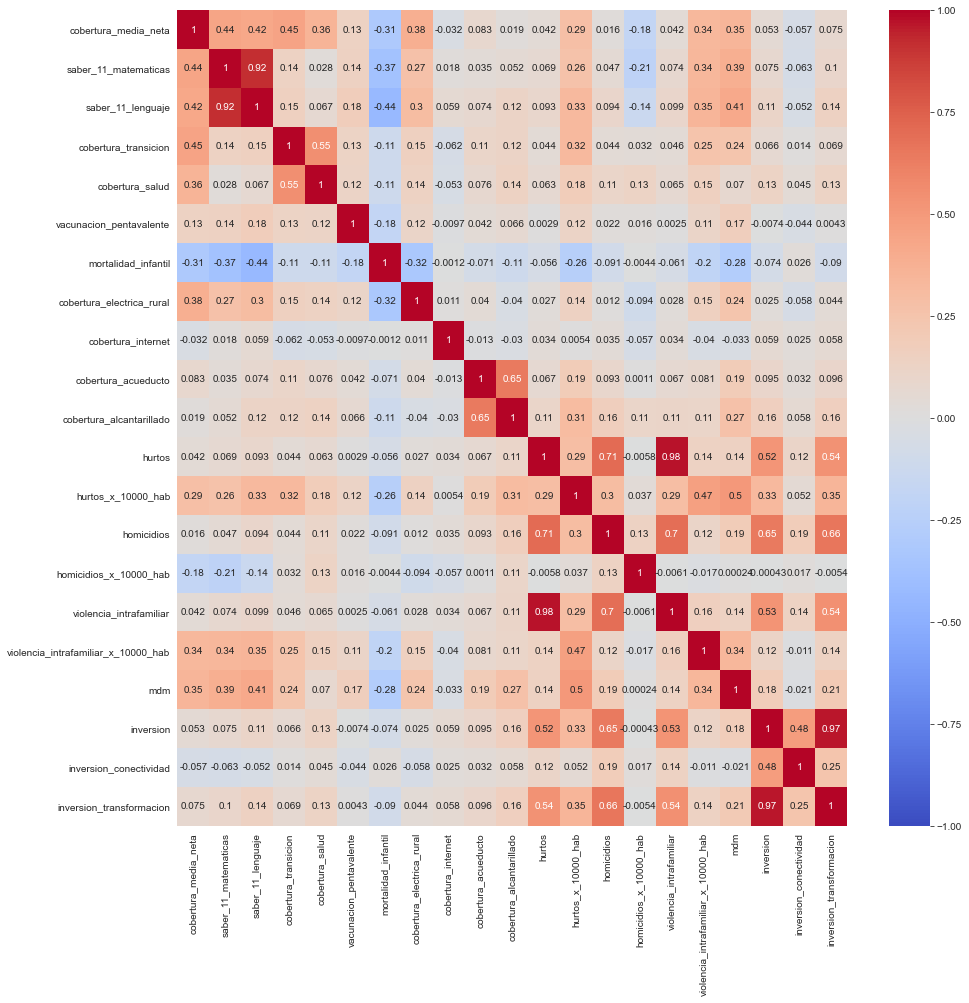

In [17]:
# Se genera un mapa de calor con la tabla de correlaciones anterior.

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)

In [18]:
# Se extraen las columnas de tipo numérico para generar poder generar varias gráficas por medio de un ciclo en la próxima celda.

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = df_merged.select_dtypes(include=numerics).columns
num_cols

Index(['cobertura_media_neta', 'saber_11_matematicas', 'saber_11_lenguaje',
       'cobertura_transicion', 'cobertura_salud', 'vacunacion_pentavalente',
       'mortalidad_infantil', 'cobertura_electrica_rural',
       'cobertura_internet', 'cobertura_acueducto', 'cobertura_alcantarillado',
       'hurtos', 'hurtos_x_10000_hab', 'homicidios', 'homicidios_x_10000_hab',
       'violencia_intrafamiliar', 'violencia_intrafamiliar_x_10000_hab', 'mdm',
       'inversion', 'inversion_conectividad', 'inversion_transformacion'],
      dtype='object')

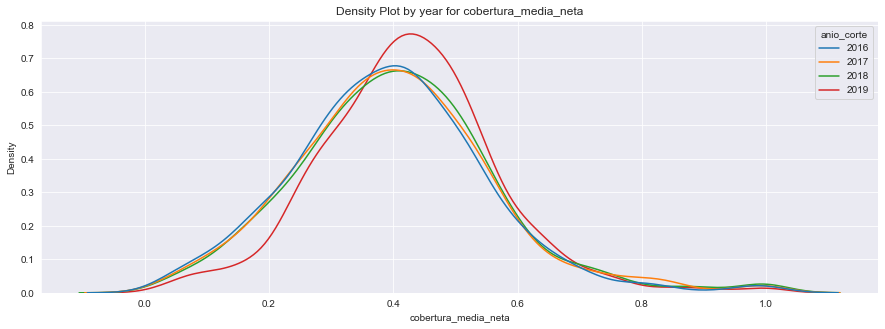

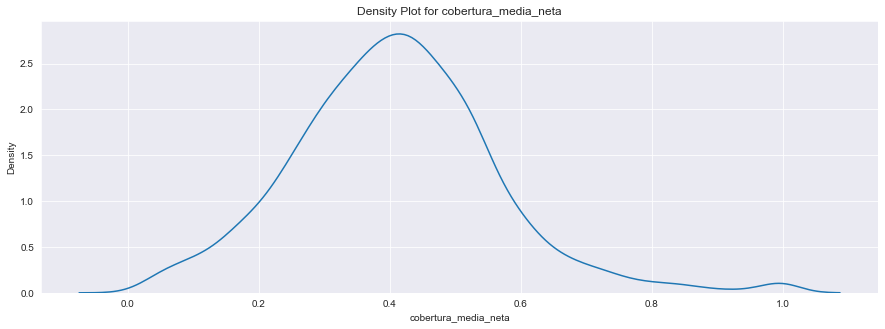

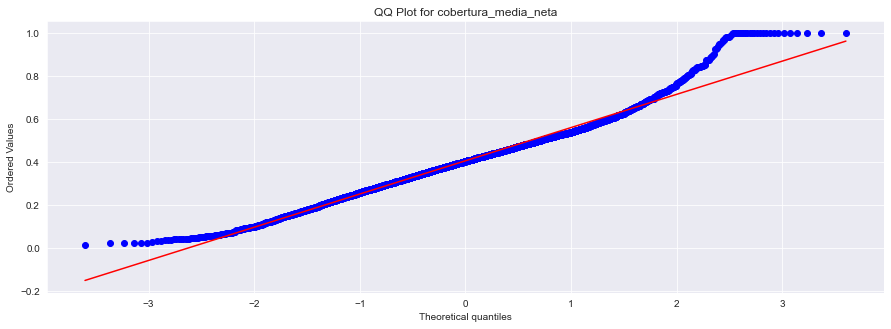

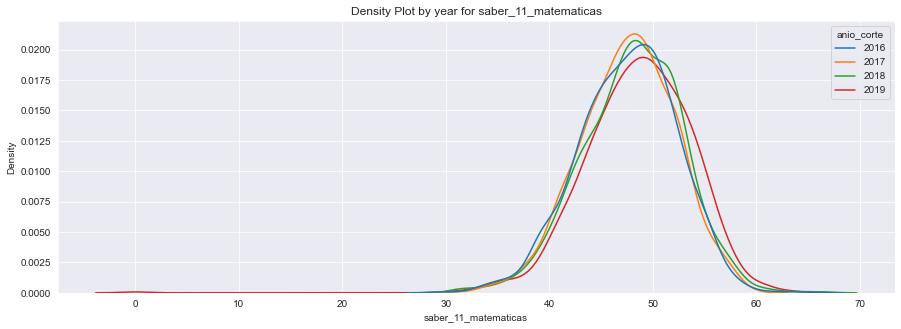

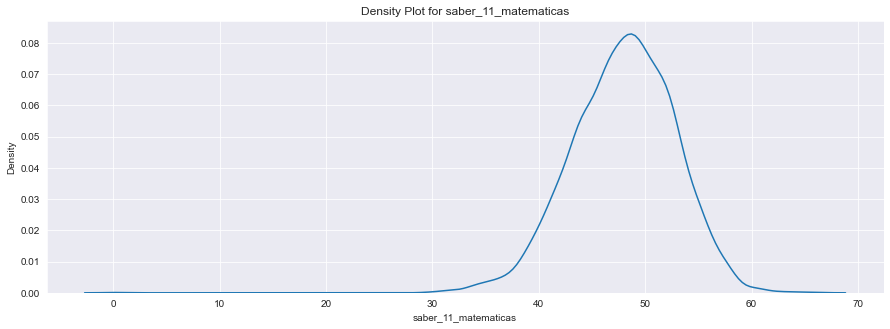

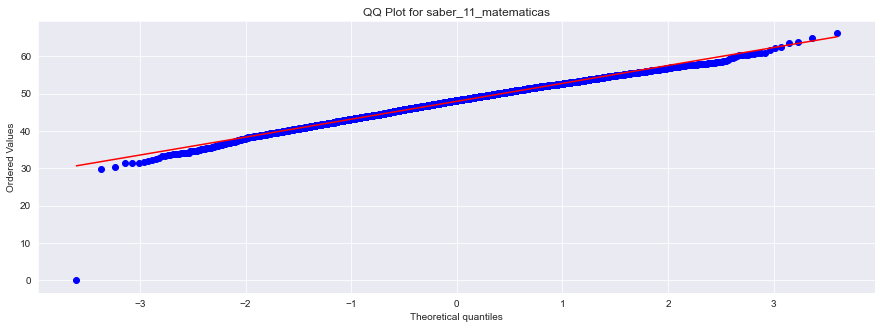

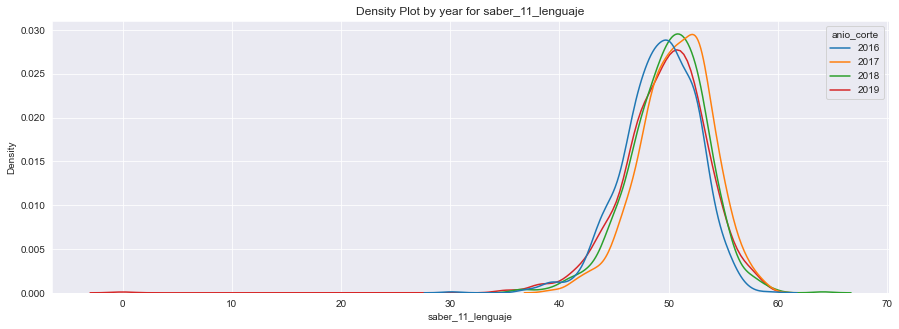

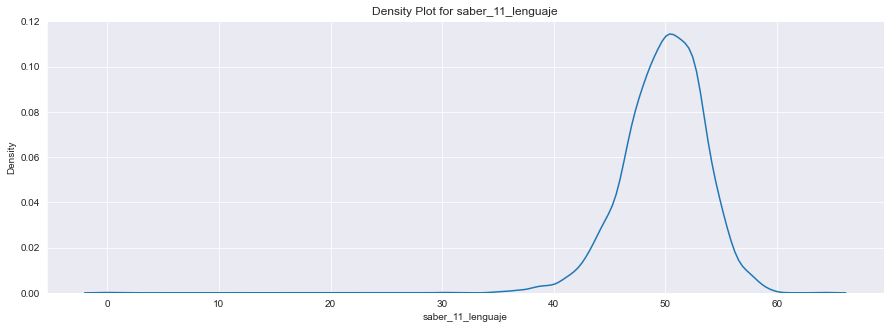

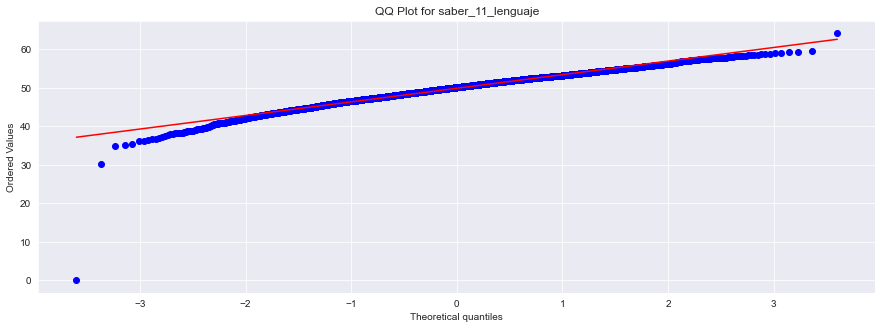

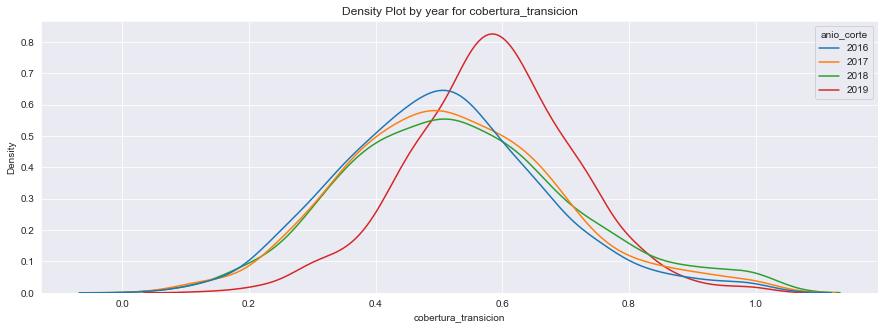

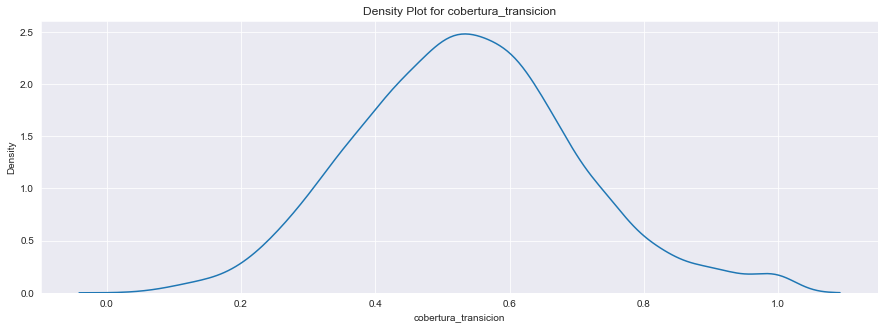

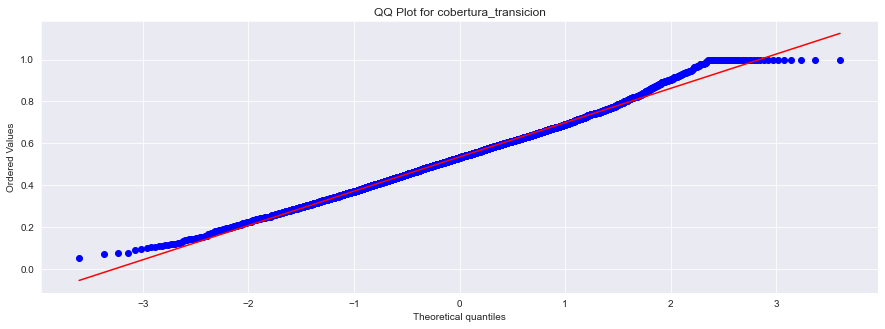

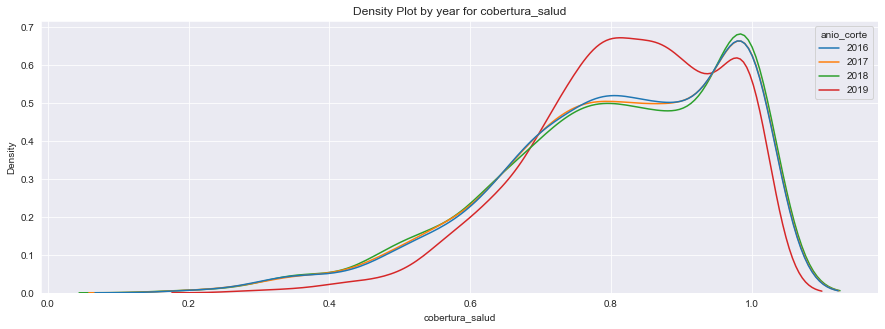

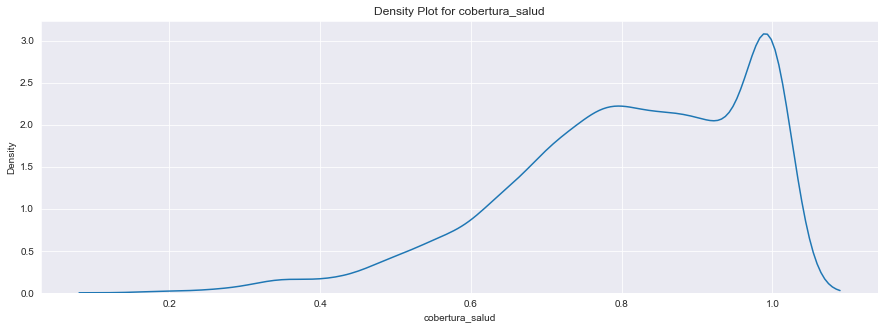

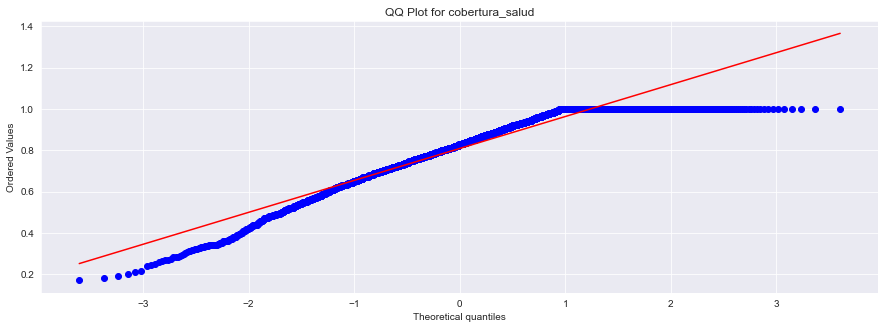

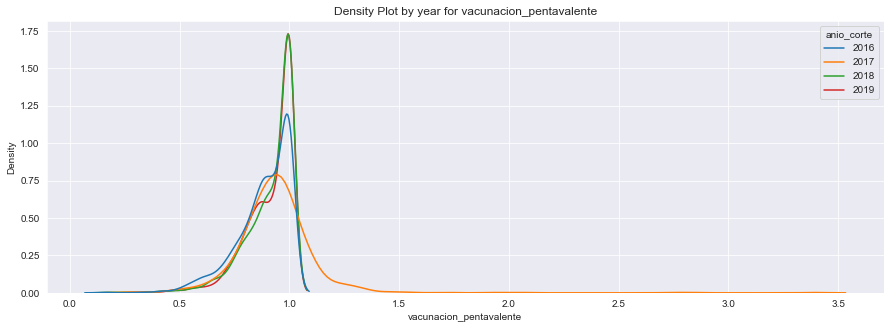

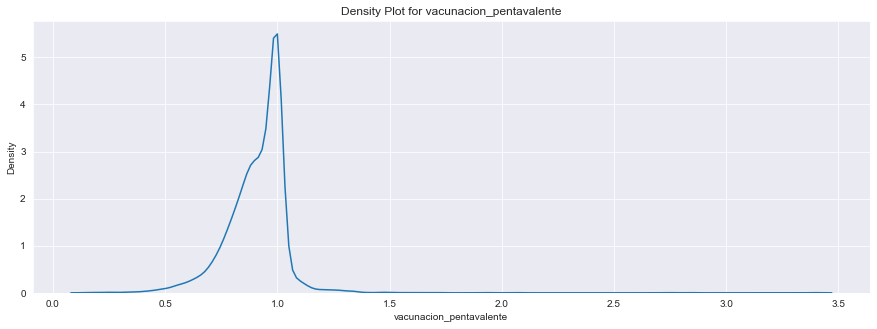

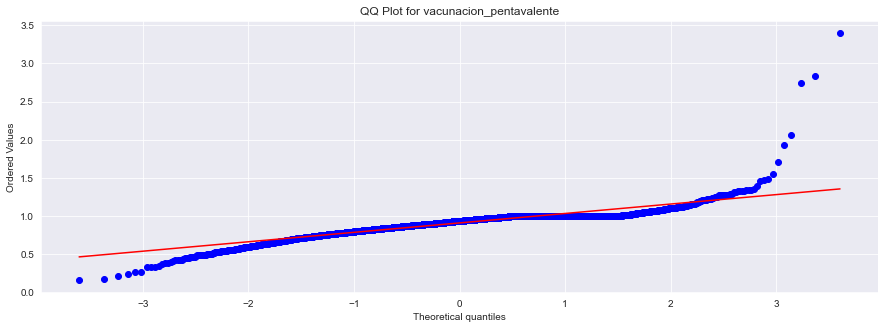

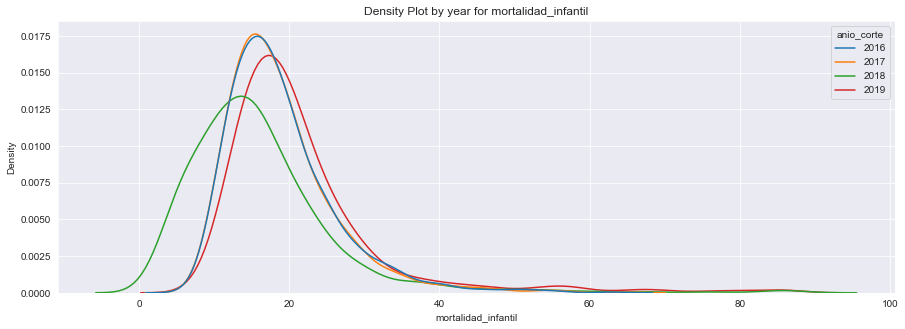

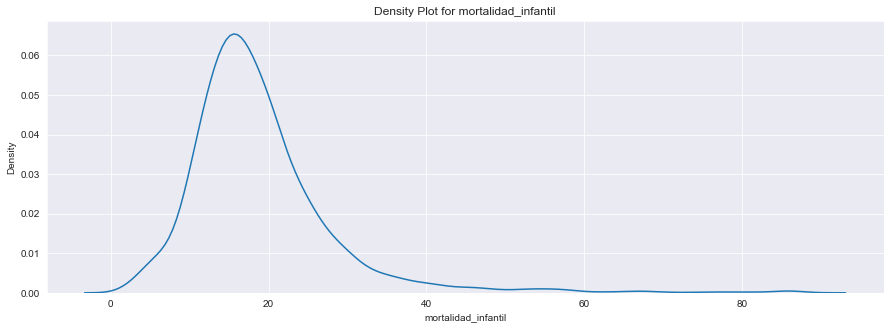

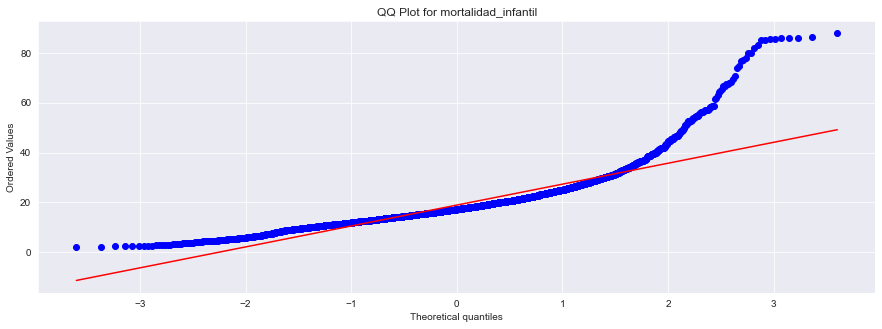

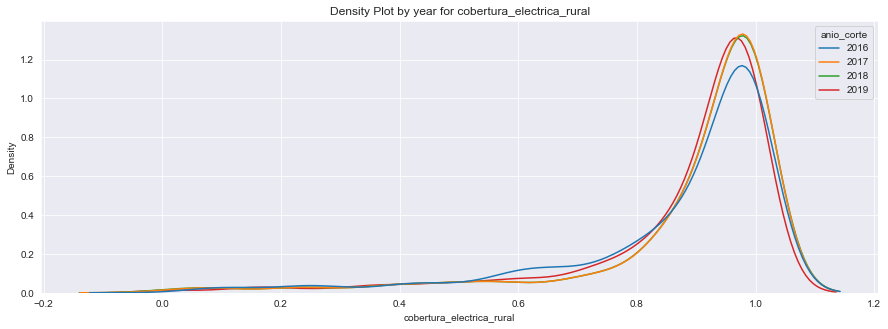

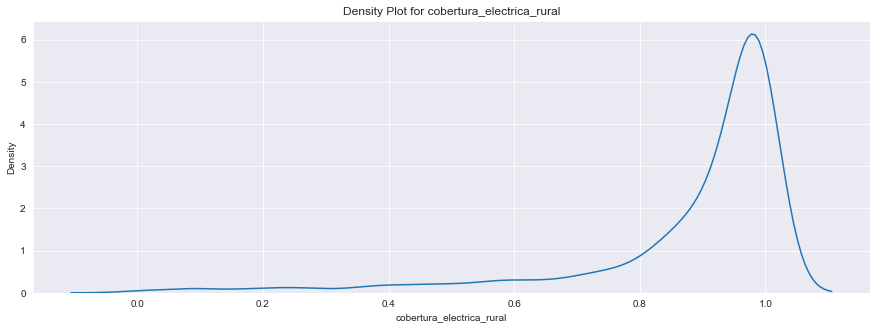

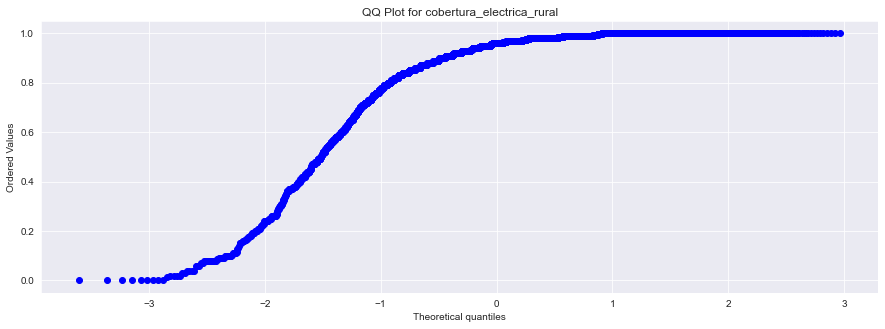

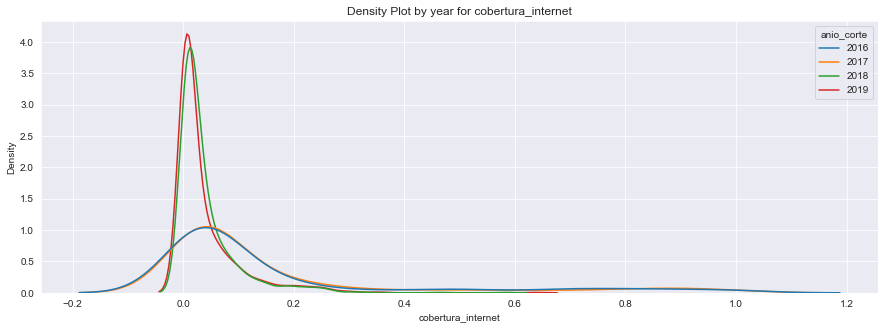

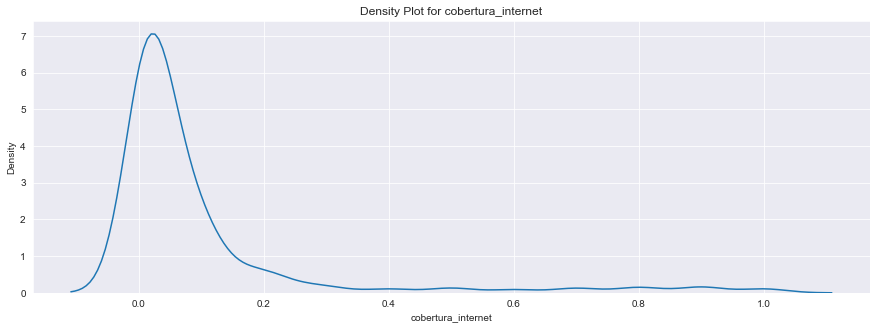

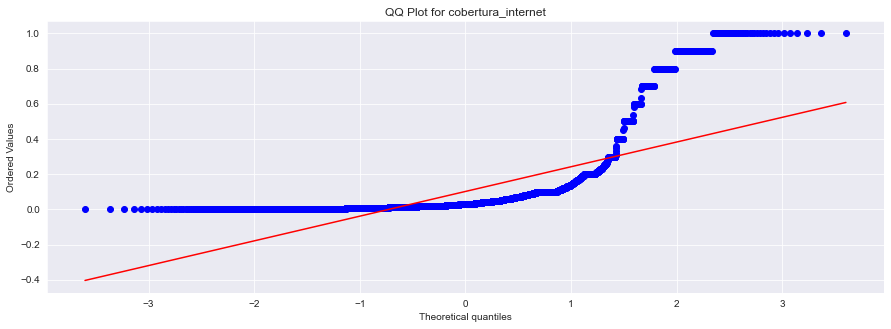

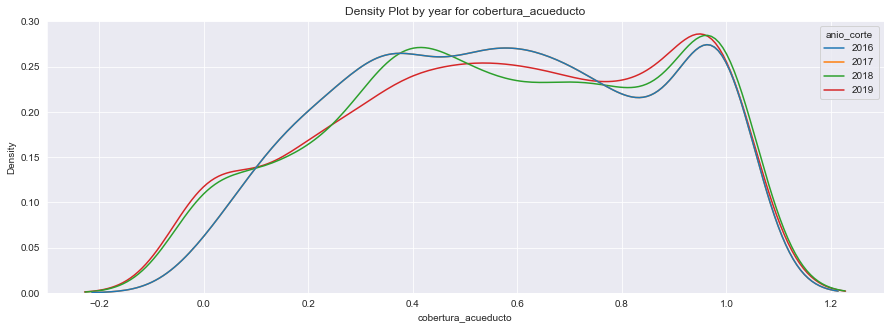

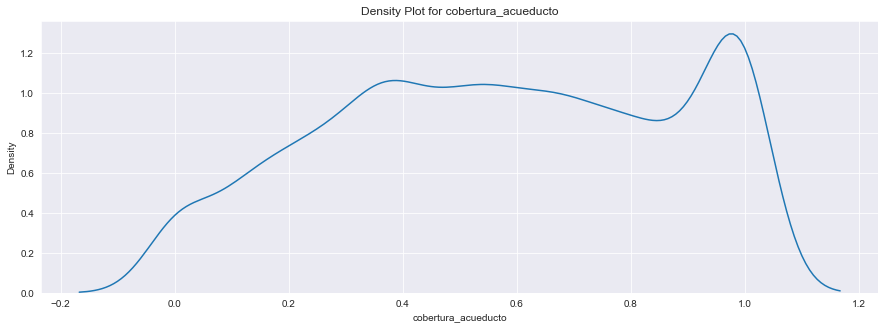

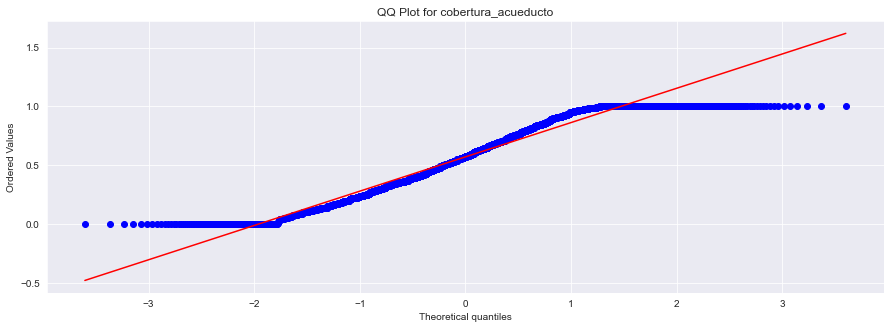

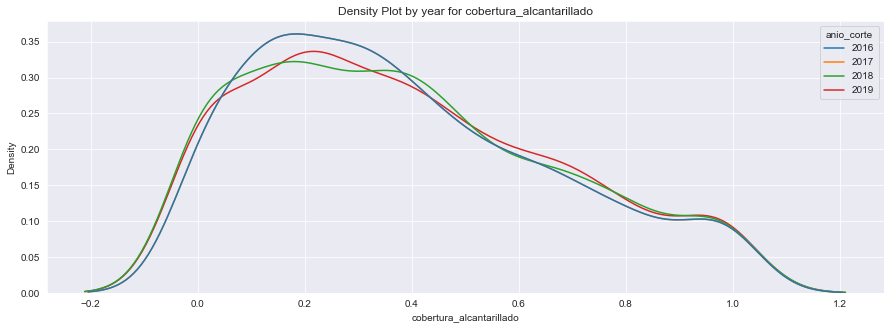

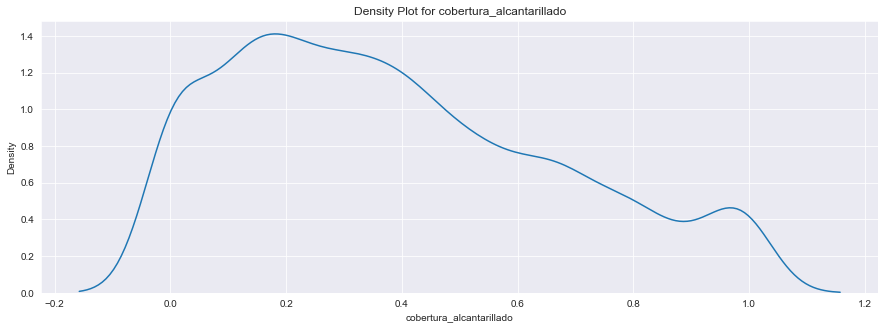

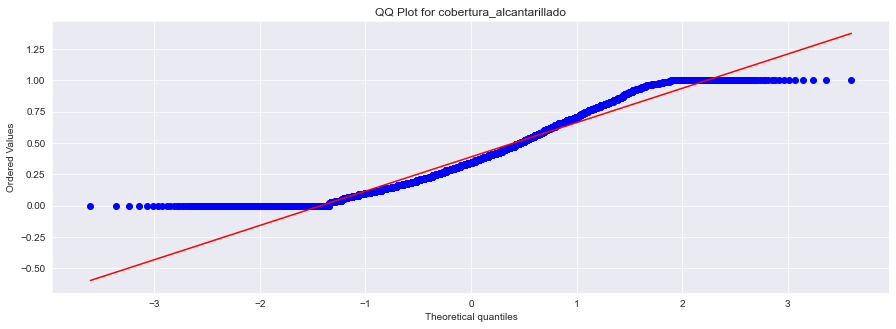

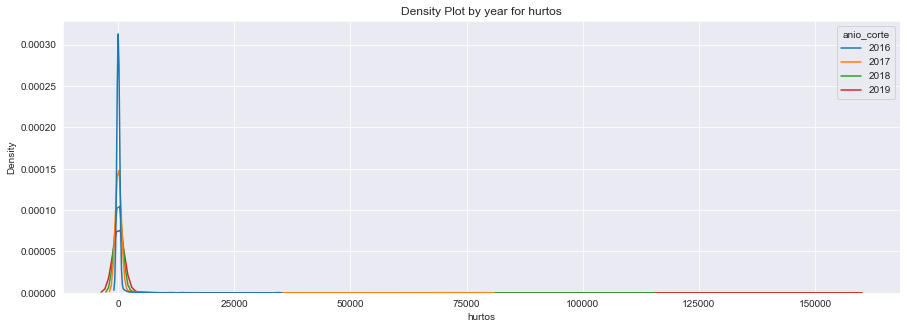

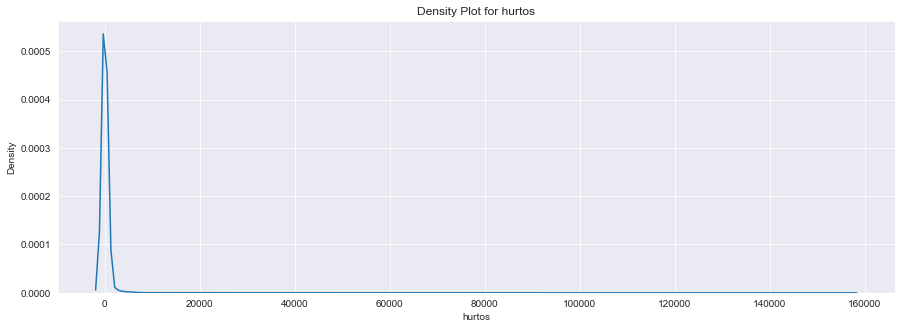

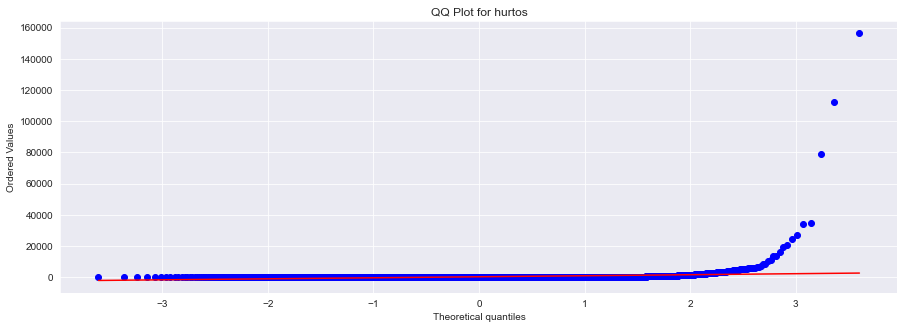

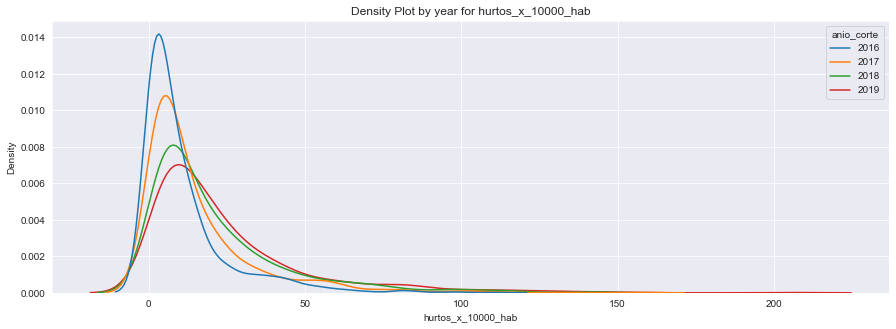

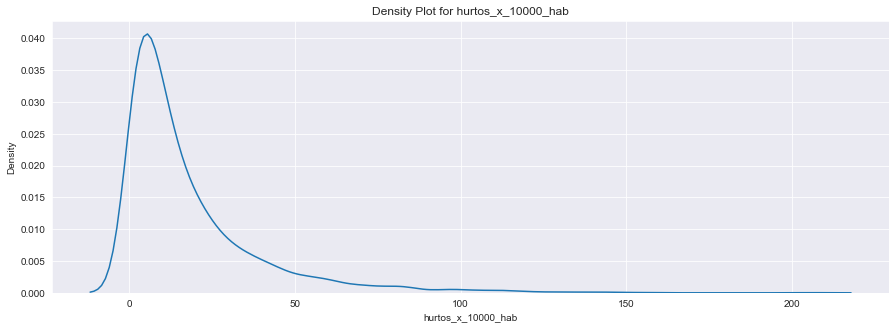

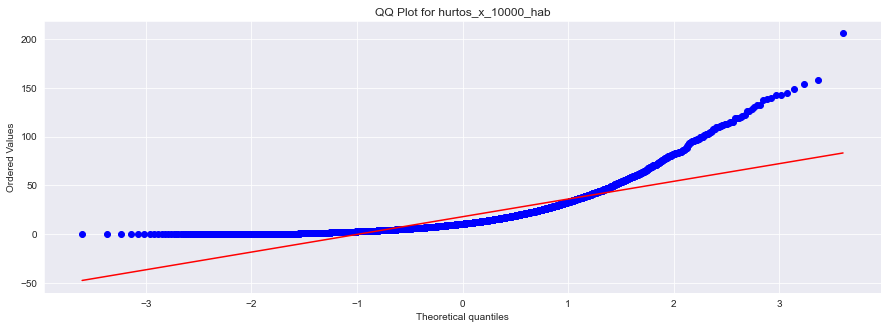

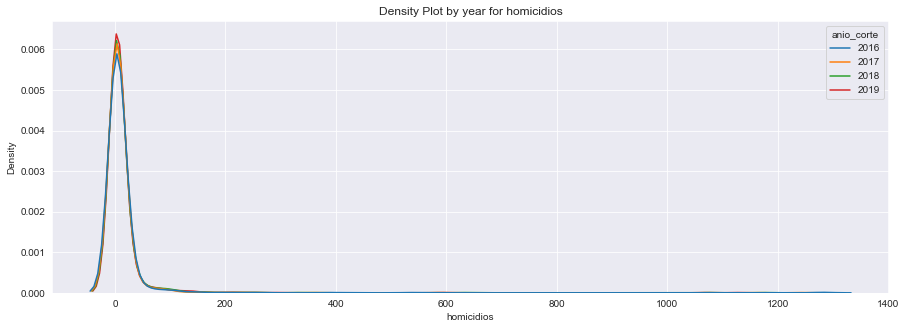

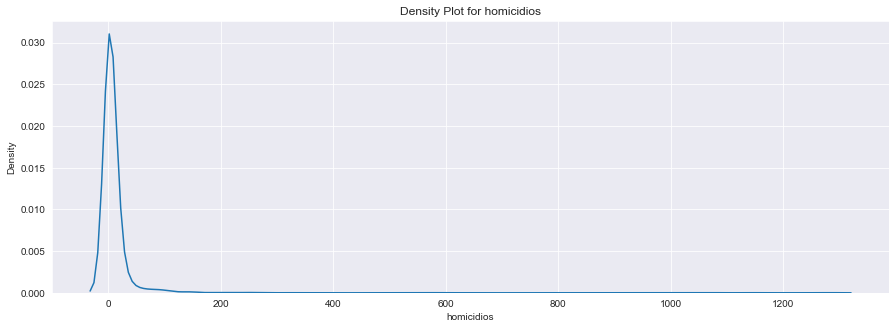

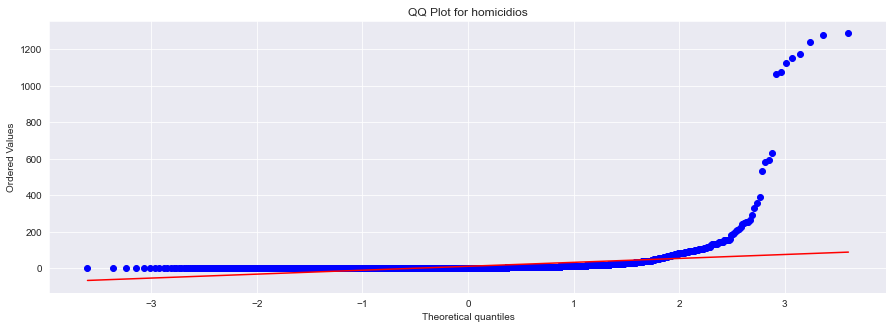

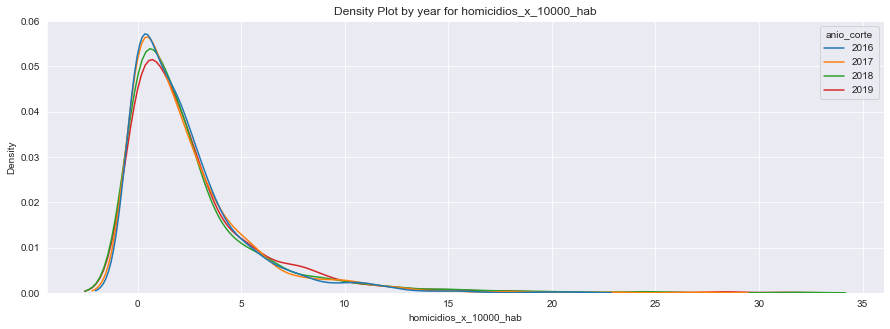

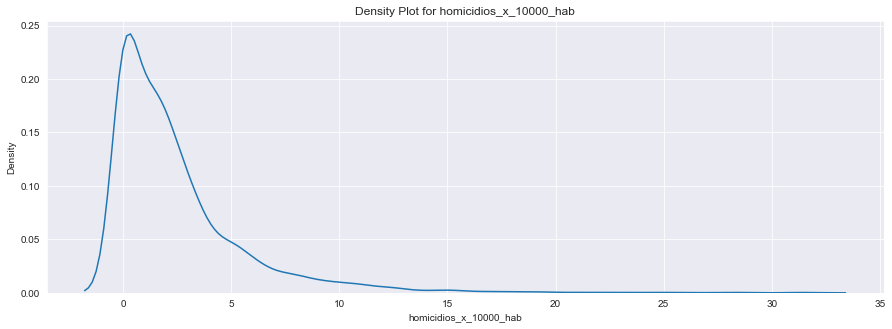

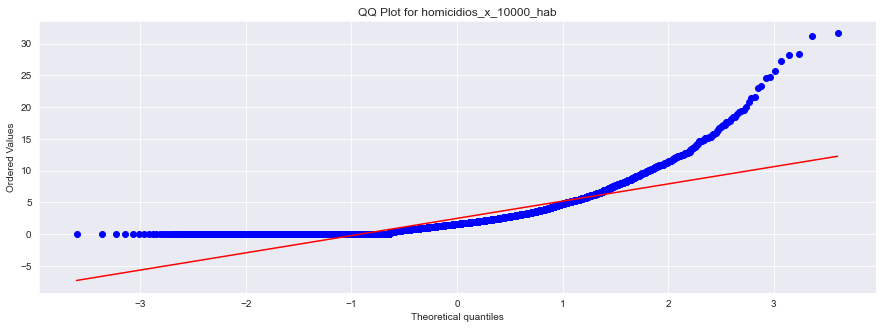

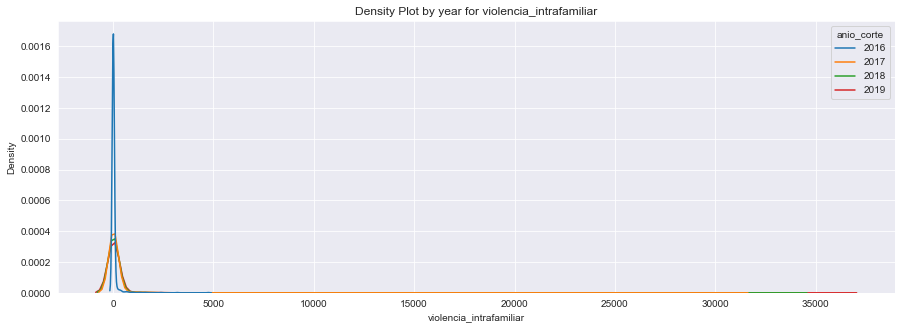

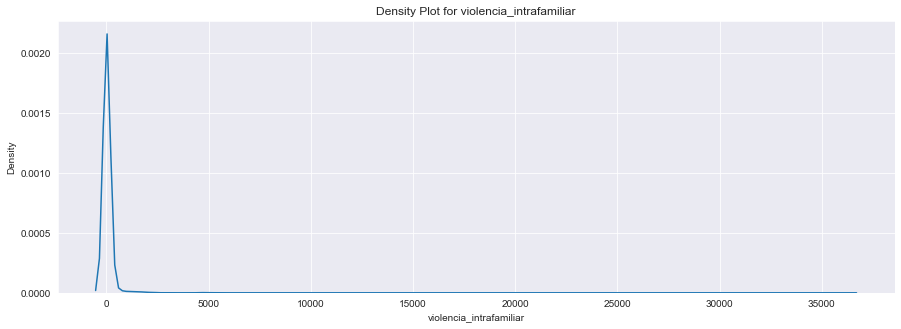

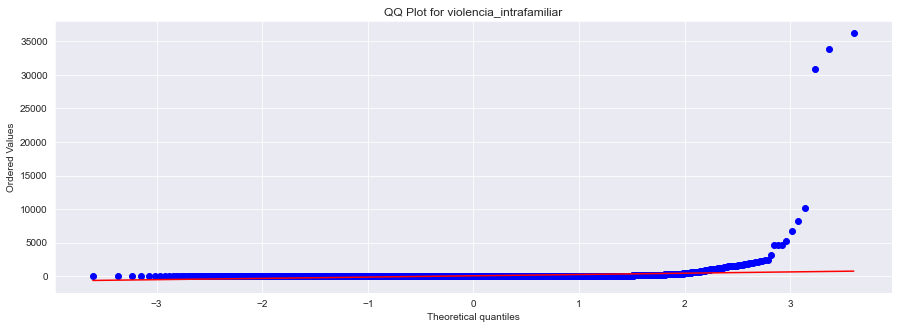

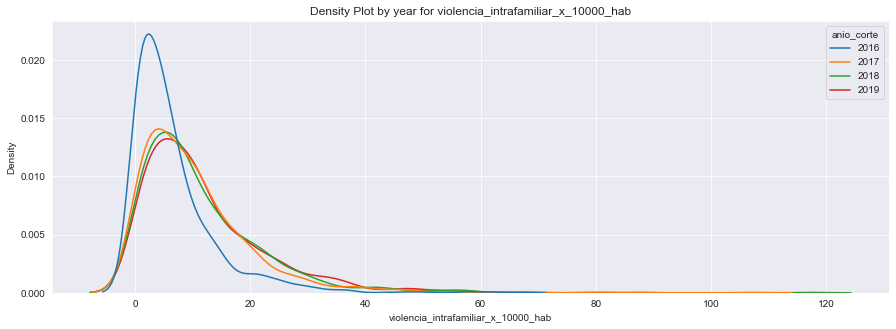

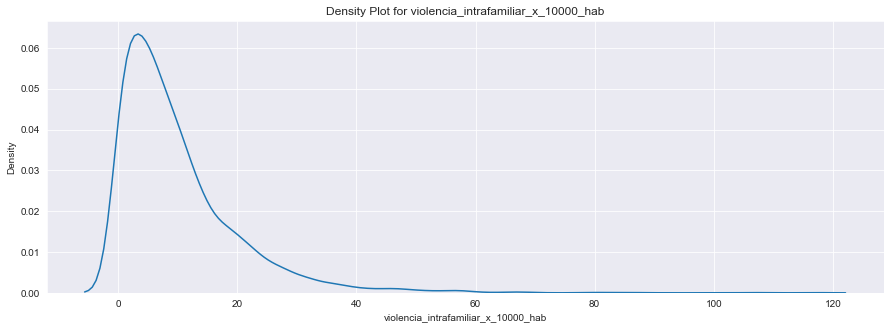

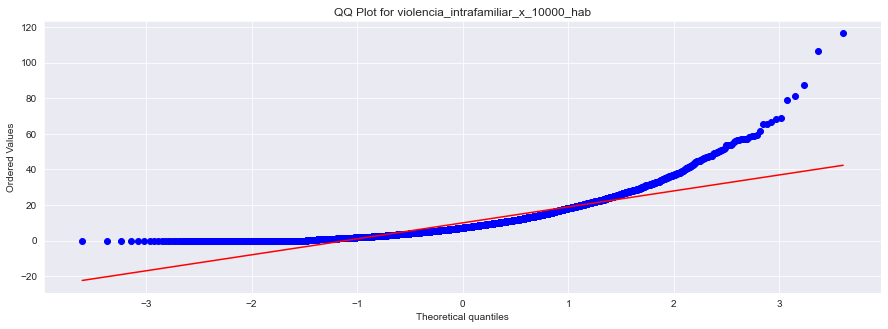

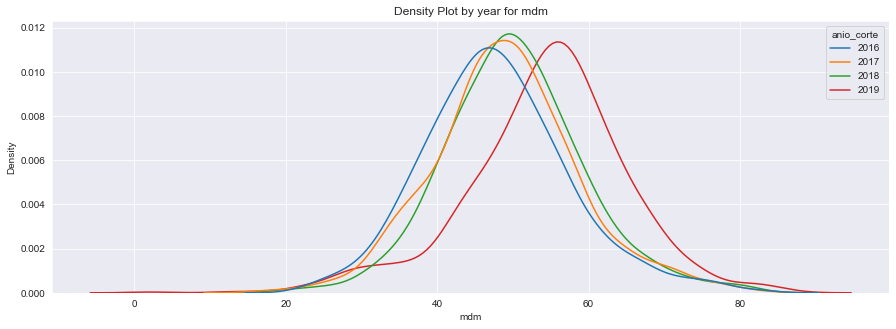

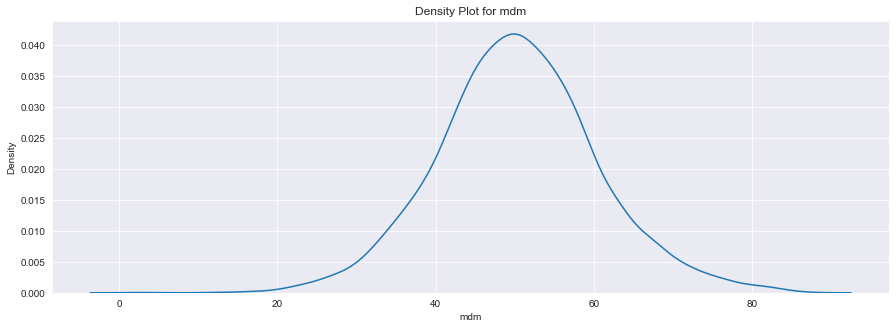

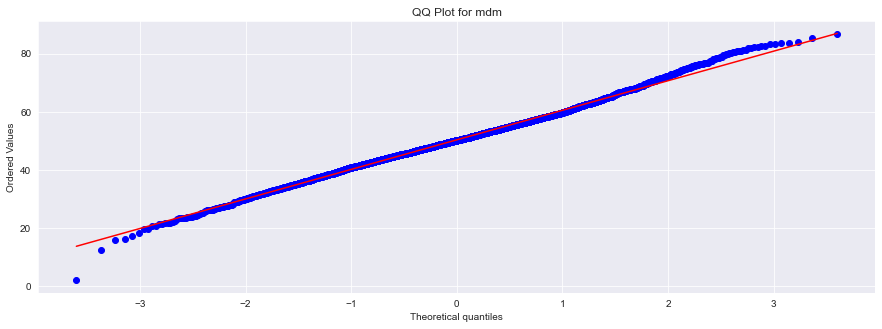

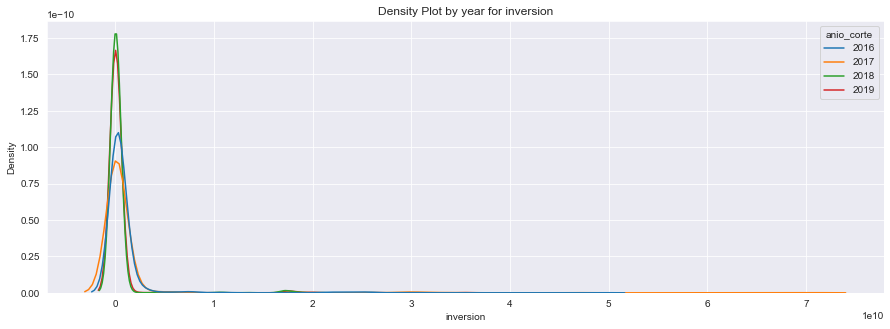

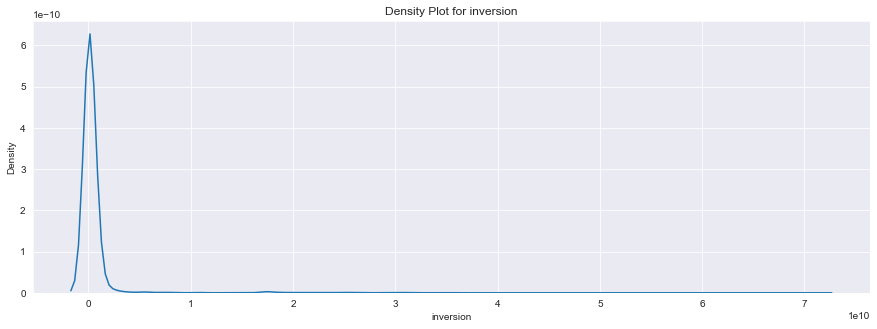

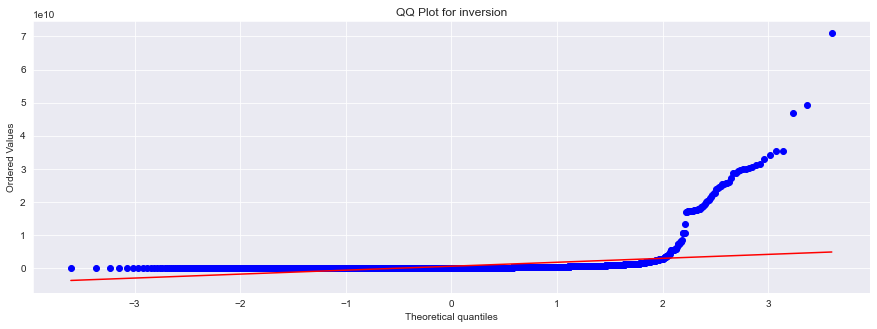

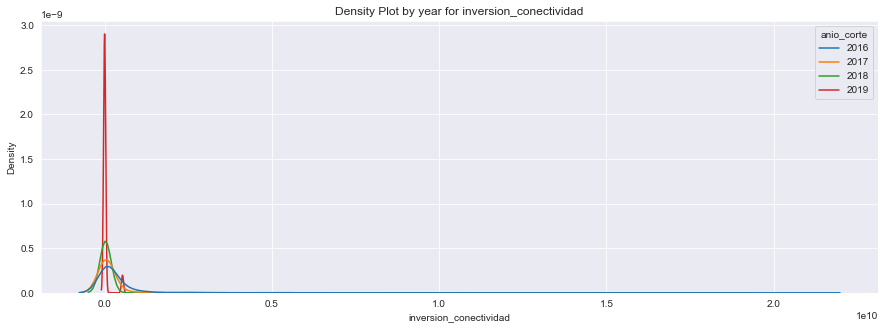

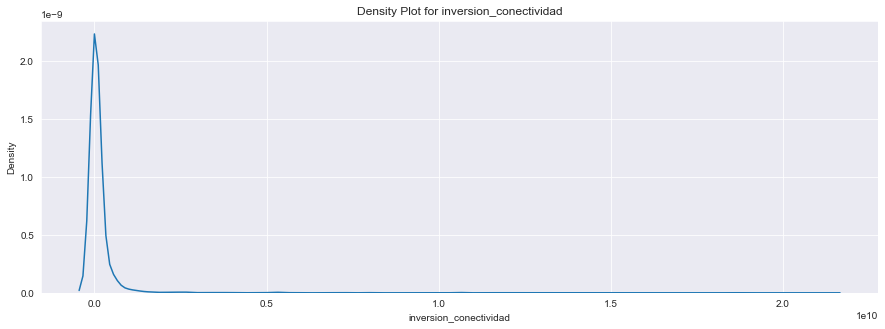

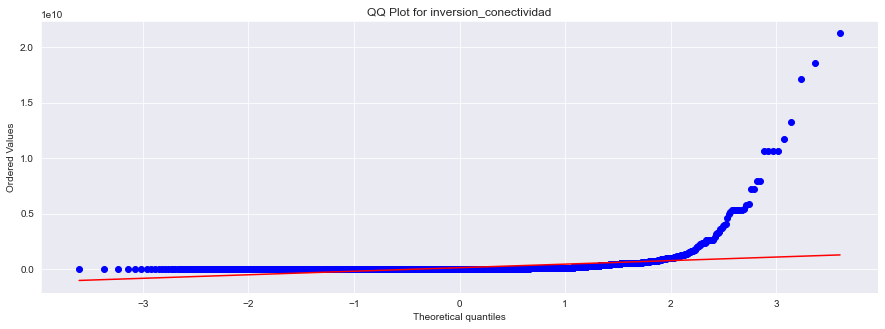

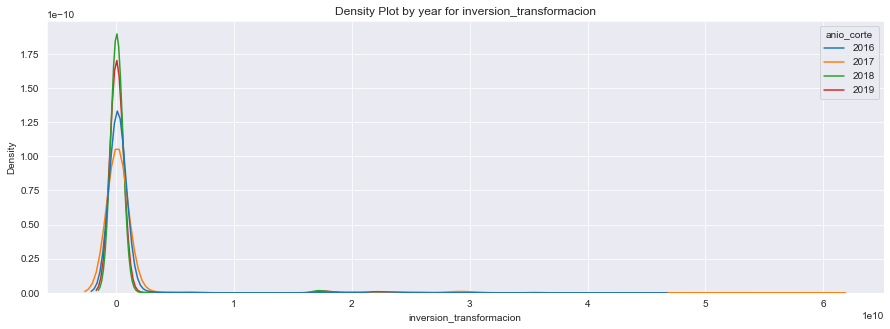

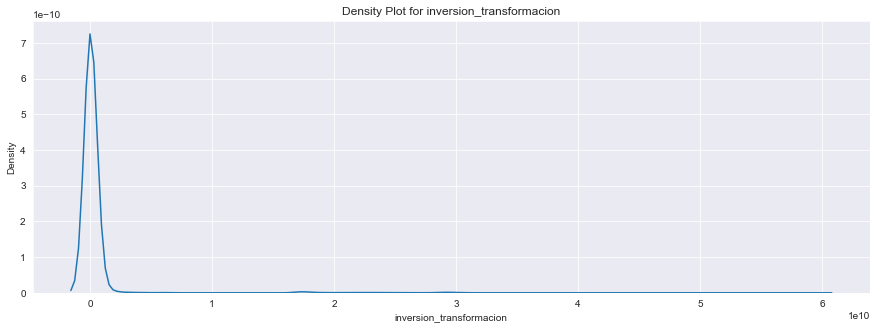

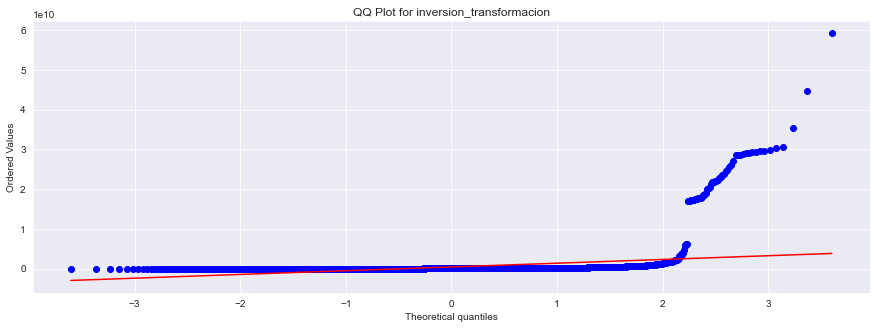

In [19]:
# Para cada una de las columnas de la celda anterior:

for col in num_cols:
    
    # Se genera un gráfico de densidad discriminando por año por año.
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.kdeplot(x = col, hue = 'anio_corte', data = df_merged)
    plt.title(f'Density Plot by year for {col}')
    plt.show()
    
    # Se genera un gráfico de densidad con los datos sin discriminar.
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.kdeplot(x = col, data = df_merged)
    plt.title(f'Density Plot for {col}')
    plt.show()
    
    # Se genera un QQ Plot para revisar normalidad.
    
    fig, ax = plt.subplots(figsize=(15, 5))
    stats.probplot(x = df_merged[col], dist="norm", plot = plt)
    plt.title(f'QQ Plot for {col}')
    plt.show()

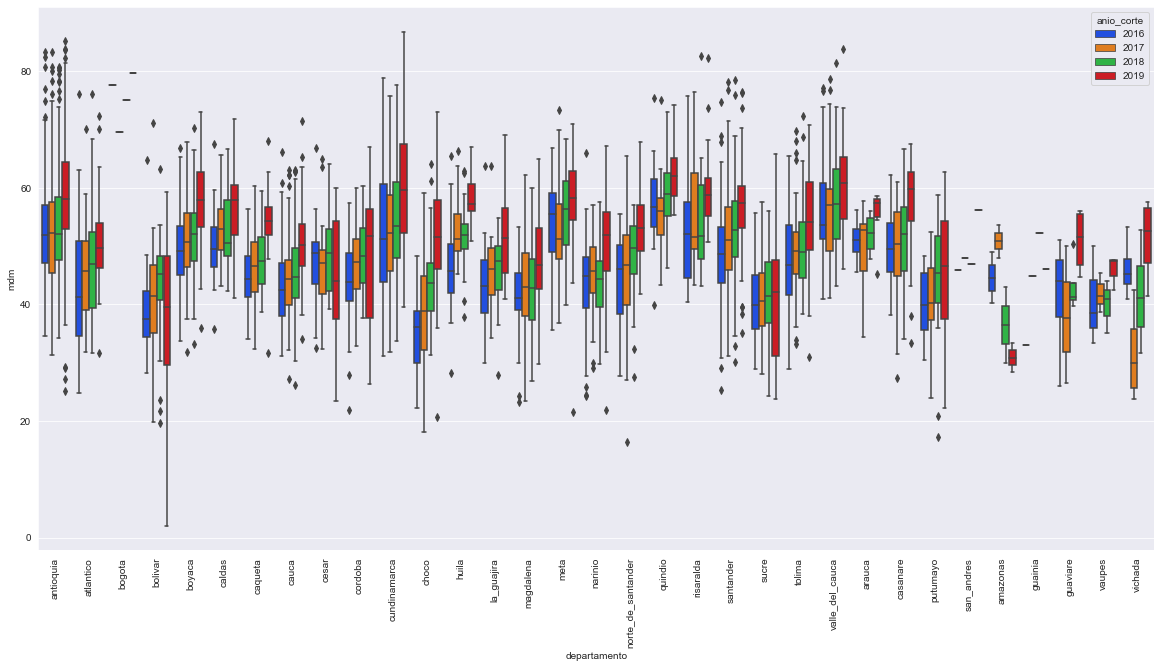

In [21]:
# Se genera un boxplot de la columna 'departamento' contra 'mdm', discriminada por año.

fig, ax = plt.subplots(figsize=(20, 10))
chart = sns.boxplot(y = 'mdm', x = 'departamento', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

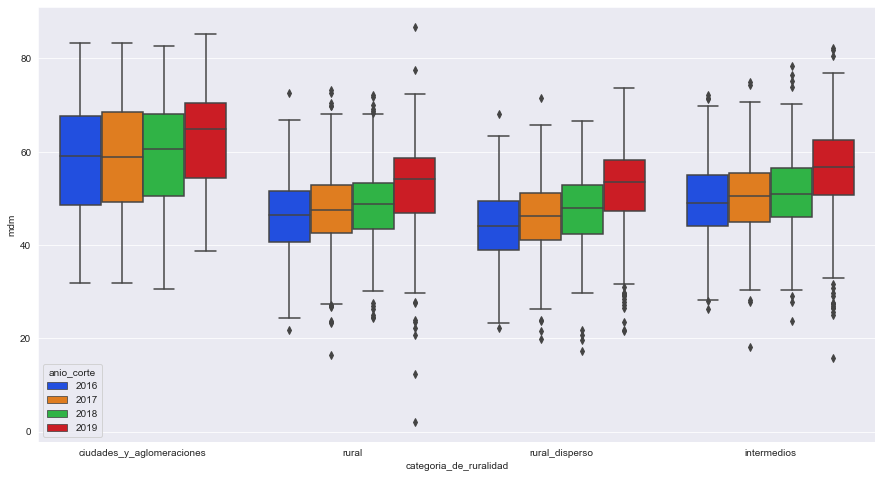

In [22]:
# Se genera un boxplot de la columna 'categoria_de_ruralidad' contra 'mdm', discriminada por año.

fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'mdm', x = 'categoria_de_ruralidad', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=0)
plt.show()

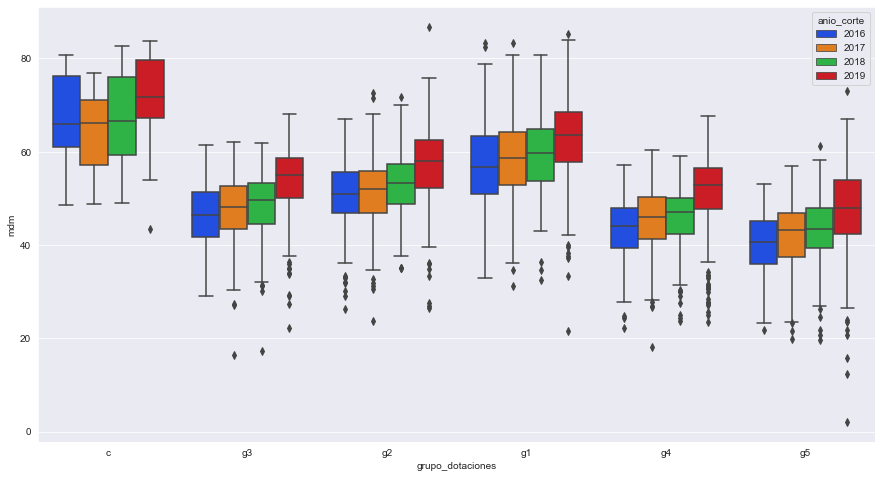

In [23]:
# Se genera un boxplot de la columna 'grupo_dotaciones' contra 'mdm', discriminada por año.

fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'mdm', x = 'grupo_dotaciones', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=0)
plt.show()

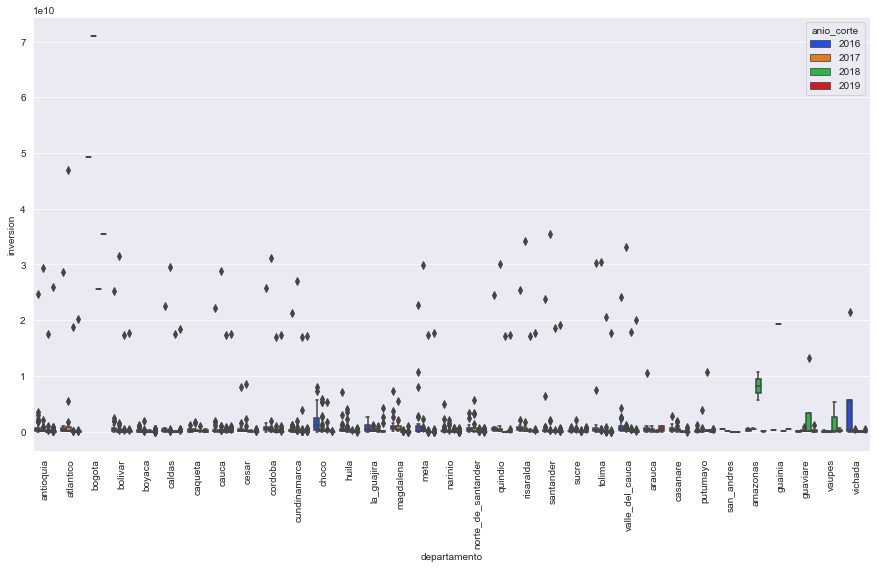

In [24]:
# Se genera un boxplot de la columna 'departamento' contra 'inversion', discriminada por año.

fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'inversion', x = 'departamento', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

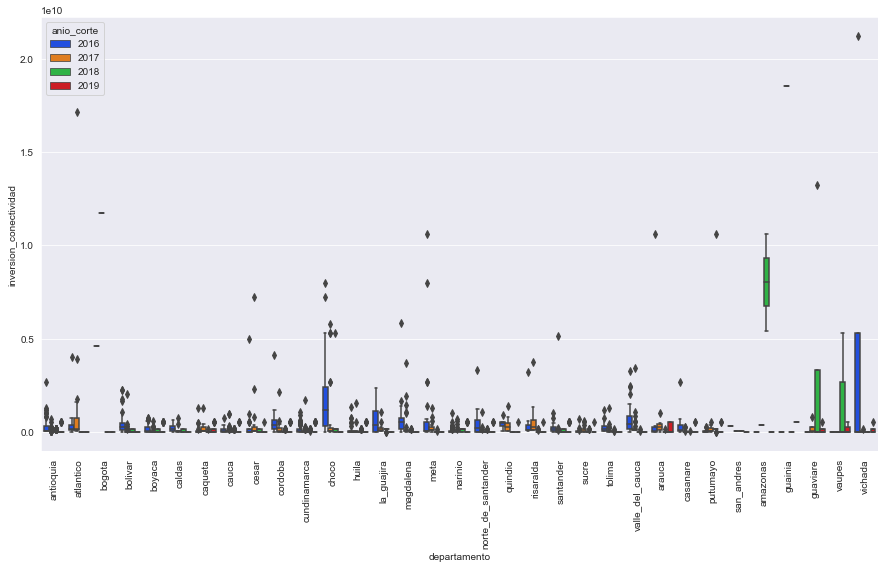

In [25]:
# Se genera un boxplot de la columna 'departamento' contra 'inversion_conectividad', discriminada por año.

fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'inversion_conectividad', x = 'departamento', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

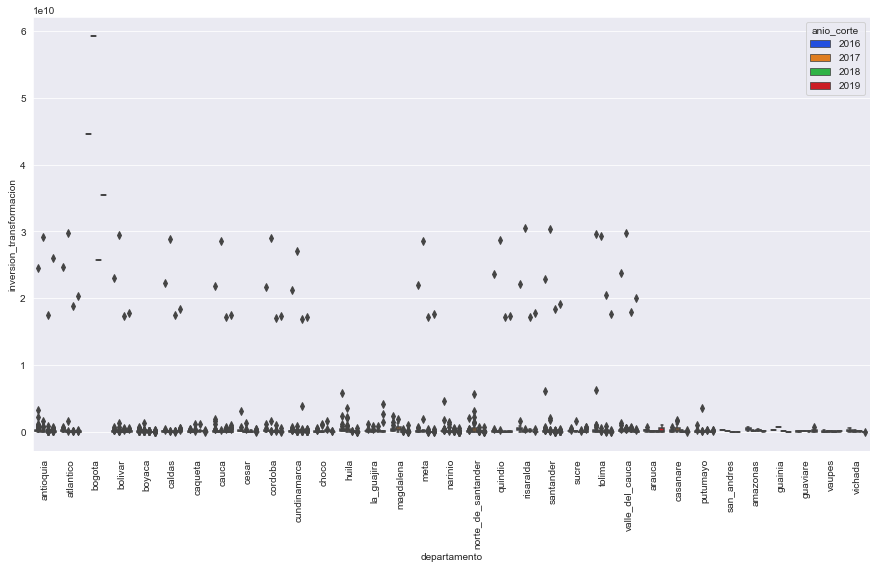

In [26]:
# Se genera un boxplot de la columna 'departamento' contra 'inversion_transformacion', discriminada por año.

fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'inversion_transformacion', x = 'departamento', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

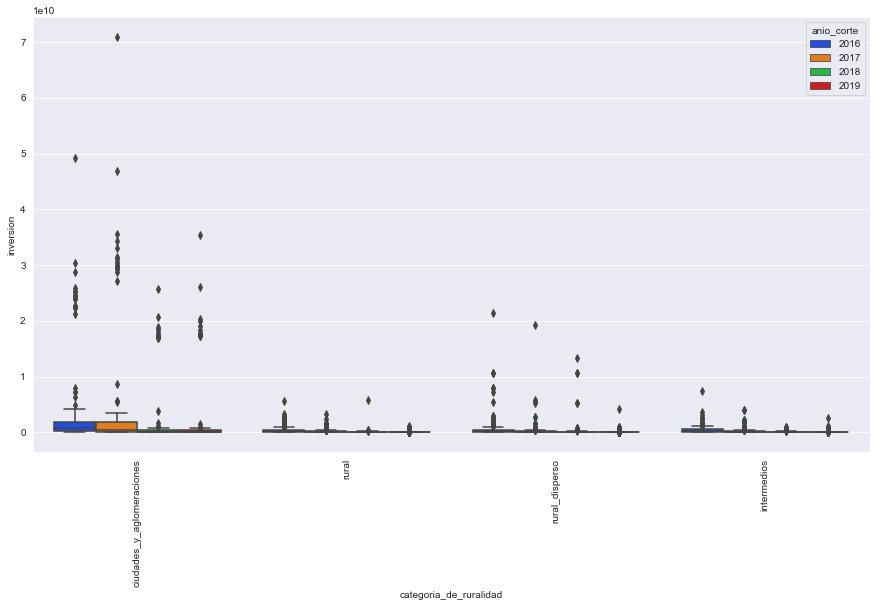

In [27]:
# Se genera un boxplot de la columna 'categoria_de_ruralidad' contra 'inversion', discriminada por año.

fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'inversion', x = 'categoria_de_ruralidad', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

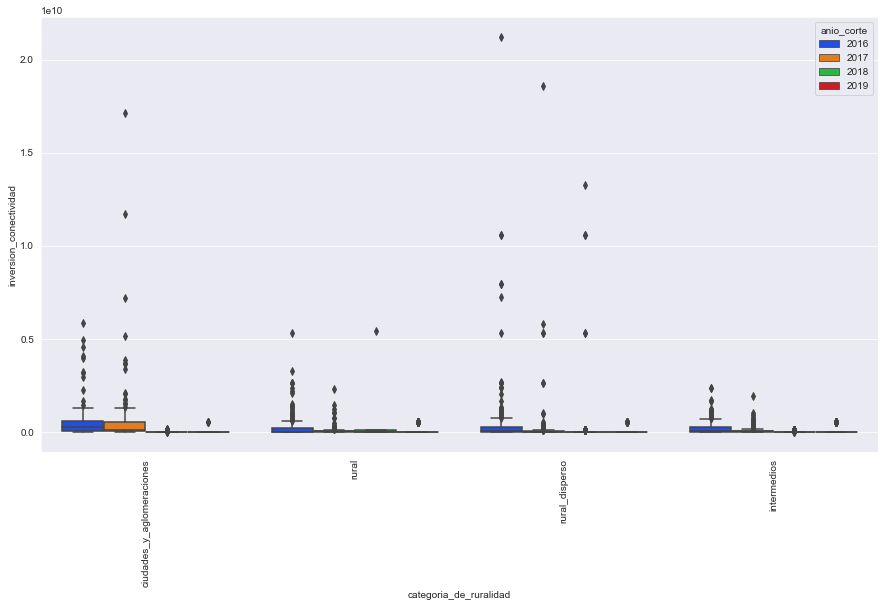

In [28]:
# Se genera un boxplot de la columna 'categoria_de_ruralidad' contra 'inversion_conectividad', discriminada por año.

fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'inversion_conectividad', x = 'categoria_de_ruralidad', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

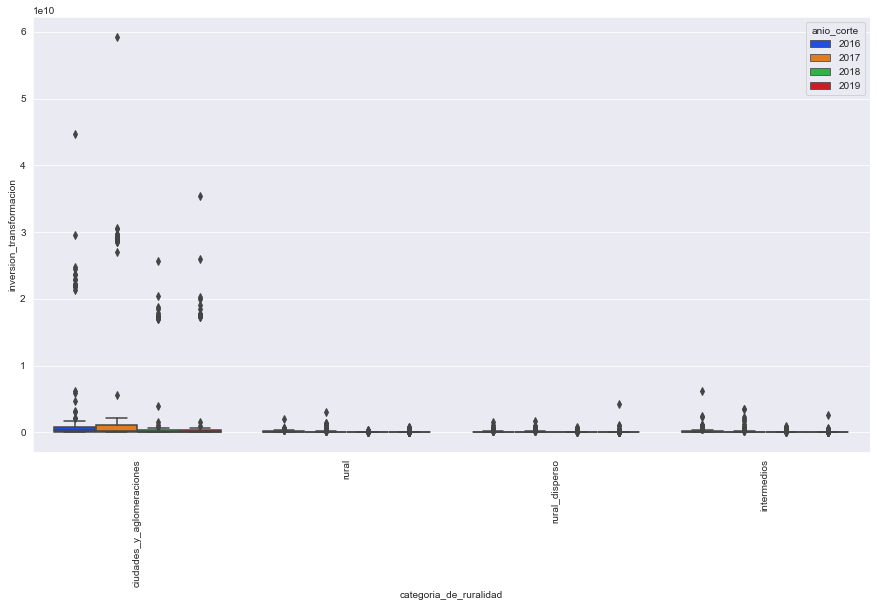

In [29]:
# Se genera un boxplot de la columna 'categoria_de_ruralidad' contra 'inversion_transformacion', discriminada por año.

fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'inversion_transformacion', x = 'categoria_de_ruralidad', ax = ax, hue = 'anio_corte', palette = 'bright', data = df_merged)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()